1. IMPORT LIBRARIES

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import ssl
import warnings

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

from sklearn.metrics import confusion_matrix , classification_report 
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score
from IPython.display import clear_output

warnings.filterwarnings('ignore')
ssl._create_default_https_context = ssl._create_unverified_context

print('import lebreries success!')

import lebreries success!


2. HYPERPARAMETRERS AND DIRECTORIES

In [30]:
train_dir = "./emotion/train"
test_dir = "./emotion/test"

SEED = 12
IMG_HEIGHT = 48
IMG_WIDTH = 48
BATCH_SIZE = 64
EPOCHS = 20
FINE_TUNING_EPOCHS = 10
LR = 0.01
NUM_CLASSES = 7
EARLY_STOPPING_CRITERIA=3
CLASS_LABELS  = ['Anger', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sadness', "Surprise"]
CLASS_LABELS_EMOJIS = ["👿", "🤢" , "😱" , "😊" , "😐 ", "😔" , "😲" ]

3. DATA LOADING AND PRE-PROCESSING

In [31]:
preprocess_fun = tf.keras.applications.densenet.preprocess_input

train_datagen = ImageDataGenerator(horizontal_flip=True,
                                   width_shift_range=0.1,
                                   height_shift_range=0.05,
                                   rescale = 1./255,
                                   validation_split = 0.2,
                                   preprocessing_function=preprocess_fun
                                  )
test_datagen = ImageDataGenerator(rescale = 1./255,
                                  validation_split = 0.2,
                                  preprocessing_function=preprocess_fun)

train_generator = train_datagen.flow_from_directory(directory = train_dir,
                                                    target_size = (IMG_HEIGHT ,IMG_WIDTH),
                                                    batch_size = BATCH_SIZE,
                                                    shuffle  = True , 
                                                    color_mode = "rgb",
                                                    class_mode = "categorical",
                                                    subset = "training",
                                                    seed = 12
                                                   )

validation_generator = test_datagen.flow_from_directory(directory = train_dir,
                                                         target_size = (IMG_HEIGHT ,IMG_WIDTH),
                                                         batch_size = BATCH_SIZE,
                                                         shuffle  = True , 
                                                         color_mode = "rgb",
                                                         class_mode = "categorical",
                                                         subset = "validation",
                                                         seed = 12
                                                        )

test_generator = test_datagen.flow_from_directory(directory = test_dir,
                                                   target_size = (IMG_HEIGHT ,IMG_WIDTH),
                                                    batch_size = BATCH_SIZE,
                                                    shuffle  = False , 
                                                    color_mode = "rgb",
                                                    class_mode = "categorical",
                                                    seed = 12
                                                  )

Found 23077 images belonging to 7 classes.
Found 5767 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


4. Images with different emotions

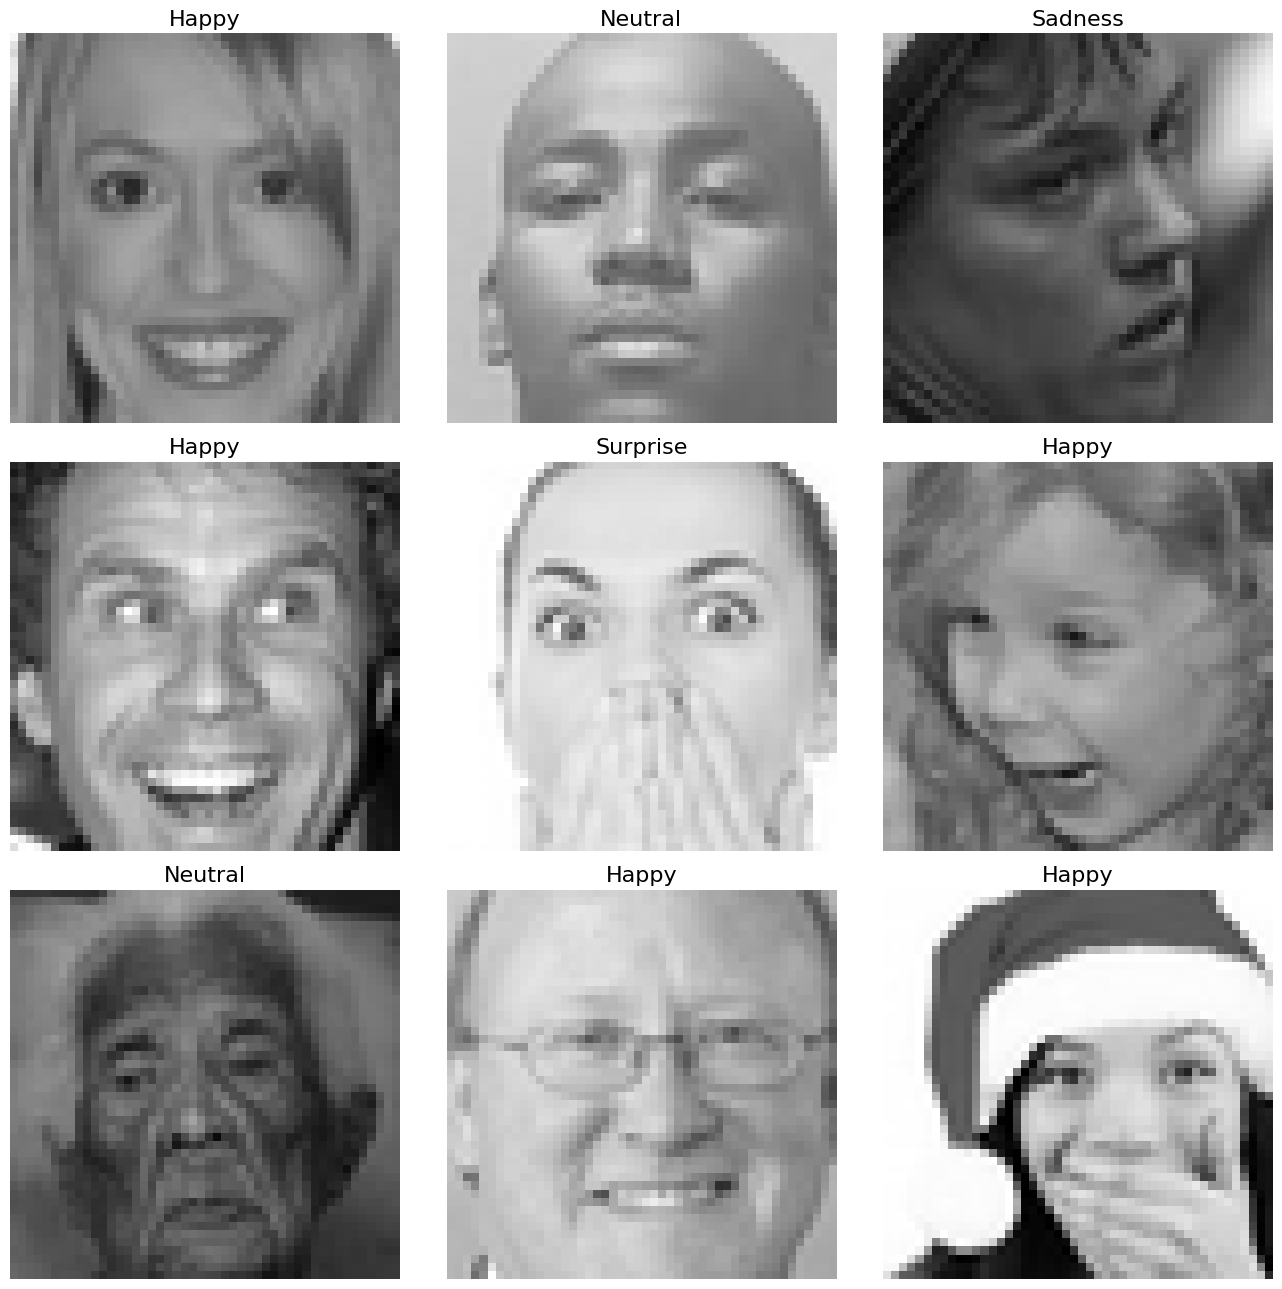

In [32]:
# Helper Functions
def display_one_image(image, title, subplot, color):
    plt.subplot(subplot)
    plt.axis('off')
    plt.imshow(image)
    plt.title(title, fontsize=16)
    
def display_nine_images(images, titles, title_colors=None):
    subplot = 331
    plt.figure(figsize=(13,13))
    for i in range(9):
        color = 'black' if title_colors is None else title_colors[i]
        display_one_image(images[i], titles[i], 331+i, color)
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.show()

def image_title(label, prediction):
  # Both prediction (probabilities) and label (one-hot) are arrays with one item per class.
    class_idx = np.argmax(label, axis=-1)
    prediction_idx = np.argmax(prediction, axis=-1)
    if class_idx == prediction_idx:
        return f'{CLASS_LABELS[prediction_idx]} [correct]', 'black'
    else:
        return f'{CLASS_LABELS[prediction_idx]} [incorrect, should be {CLASS_LABELS[class_idx]}]', 'red'

def get_titles(images, labels, model):
    predictions = model.predict(images)
    titles, colors = [], []
    for label, prediction in zip(classes, predictions):
        title, color = image_title(label, prediction)
        titles.append(title)
        colors.append(color)
    return titles, colors

img_datagen = ImageDataGenerator(rescale = 1./255)
img_generator = img_datagen.flow_from_directory(directory = train_dir,
                                                   target_size = (IMG_HEIGHT ,IMG_WIDTH),
                                                    batch_size = BATCH_SIZE,
                                                    shuffle  = True , 
                                                    color_mode = "rgb",
                                                    class_mode = "categorical",
                                                    seed = 12
                                                  )
clear_output()

images, classes = next(img_generator)
class_idxs = np.argmax(classes, axis=-1) 
labels = [CLASS_LABELS[idx] for idx in class_idxs]
display_nine_images(images, labels)

5. Data distribution (count) among differnt emotions

In [33]:
fig = px.bar(x = CLASS_LABELS_EMOJIS,
             y = [list(train_generator.classes).count(i) for i in np.unique(train_generator.classes)] , 
             color = np.unique(train_generator.classes) ,
             color_continuous_scale="Emrld") 
fig.update_xaxes(title="Emotions")
fig.update_yaxes(title = "Number of Images")
fig.update_layout(showlegend = True,
    title = {
        'text': 'Train Data Distribution ',
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
fig.show()

6. DenseNet169 Transfer Learning

In [34]:
def feature_extractor(inputs):
    feature_extractor = tf.keras.applications.DenseNet169(input_shape=(IMG_HEIGHT,IMG_WIDTH, 3),
                                               include_top=False,
                                               weights="imagenet")(inputs)
    
    return feature_extractor

def classifier(inputs):
    x = tf.keras.layers.GlobalAveragePooling2D()(inputs)
    x = tf.keras.layers.Dense(256, activation="relu", kernel_regularizer = tf.keras.regularizers.l2(0.01))(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.Dense(1024, activation="relu", kernel_regularizer = tf.keras.regularizers.l2(0.01))(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(512, activation="relu", kernel_regularizer = tf.keras.regularizers.l2(0.01))(x)
    x = tf.keras.layers.Dropout(0.5) (x)
    x = tf.keras.layers.Dense(NUM_CLASSES, activation="softmax", name="classification")(x)
    
    return x

def final_model(inputs):
    densenet_feature_extractor = feature_extractor(inputs)
    classification_output = classifier(densenet_feature_extractor)
    
    return classification_output

def define_compile_model():
    
    inputs = tf.keras.layers.Input(shape=(IMG_HEIGHT ,IMG_WIDTH,3))
    classification_output = final_model(inputs) 
    model = tf.keras.Model(inputs=inputs, outputs = classification_output)
     
    model.compile(optimizer=tf.keras.optimizers.SGD(0.1), 
                loss='categorical_crossentropy',
                metrics = ['accuracy'])
  
    return model

7. Summary of model

In [35]:
model = define_compile_model()
clear_output()

# Feezing the feature extraction layers
model.layers[1].trainable = False

model.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 48, 48, 3)]       0         
_________________________________________________________________
densenet169 (Functional)     (None, 1, 1, 1664)        12642880  
_________________________________________________________________
global_average_pooling2d_5 ( (None, 1664)              0         
_________________________________________________________________
dense_15 (Dense)             (None, 256)               426240    
_________________________________________________________________
dropout_15 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 1024)              263168    
_________________________________________________________________
dropout_16 (Dropout)         (None, 1024)              0   

Training and Fine-Tuning
8. Training model with freezed layers of DenseNer169

In [36]:
earlyStoppingCallback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                         patience=EARLY_STOPPING_CRITERIA,
                                                         verbose= 1 ,
                                                         restore_best_weights=True
                                                        )

history = model.fit(x = train_generator,
                    epochs = EPOCHS ,
                    validation_data = validation_generator , 
                    callbacks= [earlyStoppingCallback])

history = pd.DataFrame(history.history)

Epoch 1/20
361/361 [==============================] - 867s 2s/step - loss: 13.0698 - accuracy: 0.2396 - val_loss: 5.6516 - val_accuracy: 0.1847
Epoch 2/20
361/361 [==============================] - 810s 2s/step - loss: 4.1162 - accuracy: 0.4239 - val_loss: 2.3821 - val_accuracy: 0.3954
Epoch 3/20
361/361 [==============================] - 997s 3s/step - loss: 1.9910 - accuracy: 0.4832 - val_loss: 1.5877 - val_accuracy: 0.5117
Epoch 4/20
361/361 [==============================] - 759s 2s/step - loss: 1.4400 - accuracy: 0.5294 - val_loss: 1.3744 - val_accuracy: 0.5256
Epoch 5/20
361/361 [==============================] - 841s 2s/step - loss: 1.2733 - accuracy: 0.5599 - val_loss: 1.3076 - val_accuracy: 0.5356
Epoch 6/20
361/361 [==============================] - 769s 2s/step - loss: 1.2118 - accuracy: 0.5776 - val_loss: 1.2166 - val_accuracy: 0.5682
Epoch 7/20
361/361 [==============================] - 783s 2s/step - loss: 1.1641 - accuracy: 0.5926 - val_loss: 1.2564 - val_accuracy: 0.559

KeyboardInterrupt: 

In [37]:
import plotly.graph_objects as go

best_epoch = len(history)
if earlyStoppingCallback.stopped_epoch != None:
    best_epoch = earlyStoppingCallback.stopped_epoch + 1
history.loc[best_epoch] = [history.loc[best_epoch-1, 'accuracy'], 
                           history.loc[best_epoch-1, 'loss'], 
                           history.loc[best_epoch-1, 'val_accuracy'], 
                           history.loc[best_epoch-1, 'val_loss']]

fig = go.Figure()

fig.add_trace(go.Scatter(x=history.index, y=history['accuracy'], mode='lines', name='Training Accuracy'))
fig.add_trace(go.Scatter(x=history.index, y=history['val_accuracy'], mode='lines', name='Validation Accuracy'))

# Menambahkan bullet point pada titik optimal
fig.add_trace(go.Scatter(x=[best_epoch], y=[history.loc[best_epoch, 'val_accuracy']], mode='markers', name='Optimal Model',
                         marker=dict(color='green', size=10, symbol='circle')))

fig.update_xaxes(title="Number of Epochs")
fig.update_yaxes(title="Accuracy")
fig.update_layout(showlegend=True,
                  title='Accuracy vs Number of Epochs',
                  xaxis_title='Number of Epochs',
                  yaxis_title='Accuracy',
                  annotations=[
                      dict(
                          x=best_epoch,
                          y=history.loc[best_epoch, 'val_accuracy'],
                          xref="x",
                          yref="y",
                          text="Optimal Model",
                          showarrow=True,
                          arrowhead=7,
                          ax=0,
                          ay=-40
                      )
                  ]
)

fig.show()

9. Fine Tuning

In [38]:
# Un-Freezing the feature extraction layers for fine tuning 
model.layers[1].trainable = True

model.compile(optimizer=tf.keras.optimizers.SGD(0.001), #lower learning rate
                loss='categorical_crossentropy',
                metrics = ['accuracy'])

history_ = model.fit(x = train_generator,epochs = FINE_TUNING_EPOCHS ,validation_data = validation_generator)
history = history.append(pd.DataFrame(history_.history) , ignore_index=True)
# save model structure in json file
model_json = model.to_json()
with open('emotion_model_json', "w") as json_file:
    json_file.write(model_json)

# save trained model weights in .h5 file
model.save_weights('emotion_model_h5')

Epoch 1/10
266/361 [=====================>........] - ETA: 3:01 - loss: 1.0782 - accuracy: 0.6264

KeyboardInterrupt: 

10. Training plots

In [39]:
x = px.line(data_frame= history , y= ["accuracy" , "val_accuracy"] ,markers = True )
x.update_xaxes(title="Number of Epochs")
x.update_yaxes(title = "Accuracy")
x.update_layout(showlegend = True,
    title = {
        'text': 'Accuracy vs Number of Epochs',
        'y':0.94,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
x.show()

In [40]:
x = px.line(data_frame= history , 
            y= ["loss" , "val_loss"] , markers = True )
x.update_xaxes(title="Number of Epochs")
x.update_yaxes(title = "Loss")
x.update_layout(showlegend = True,
    title = {
        'text': 'Loss vs Number of Epochs',
        'y':0.94,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
x.show()

11. Model Evaluation

In [41]:
model.evaluate(test_generator)
preds = model.predict(test_generator)
y_preds = np.argmax(preds , axis = 1 )
y_test = np.array(test_generator.labels)

113/113 [==============================] - 49s 400ms/step - loss: 1.0949 - accuracy: 0.6154


12. Confusion Matrix

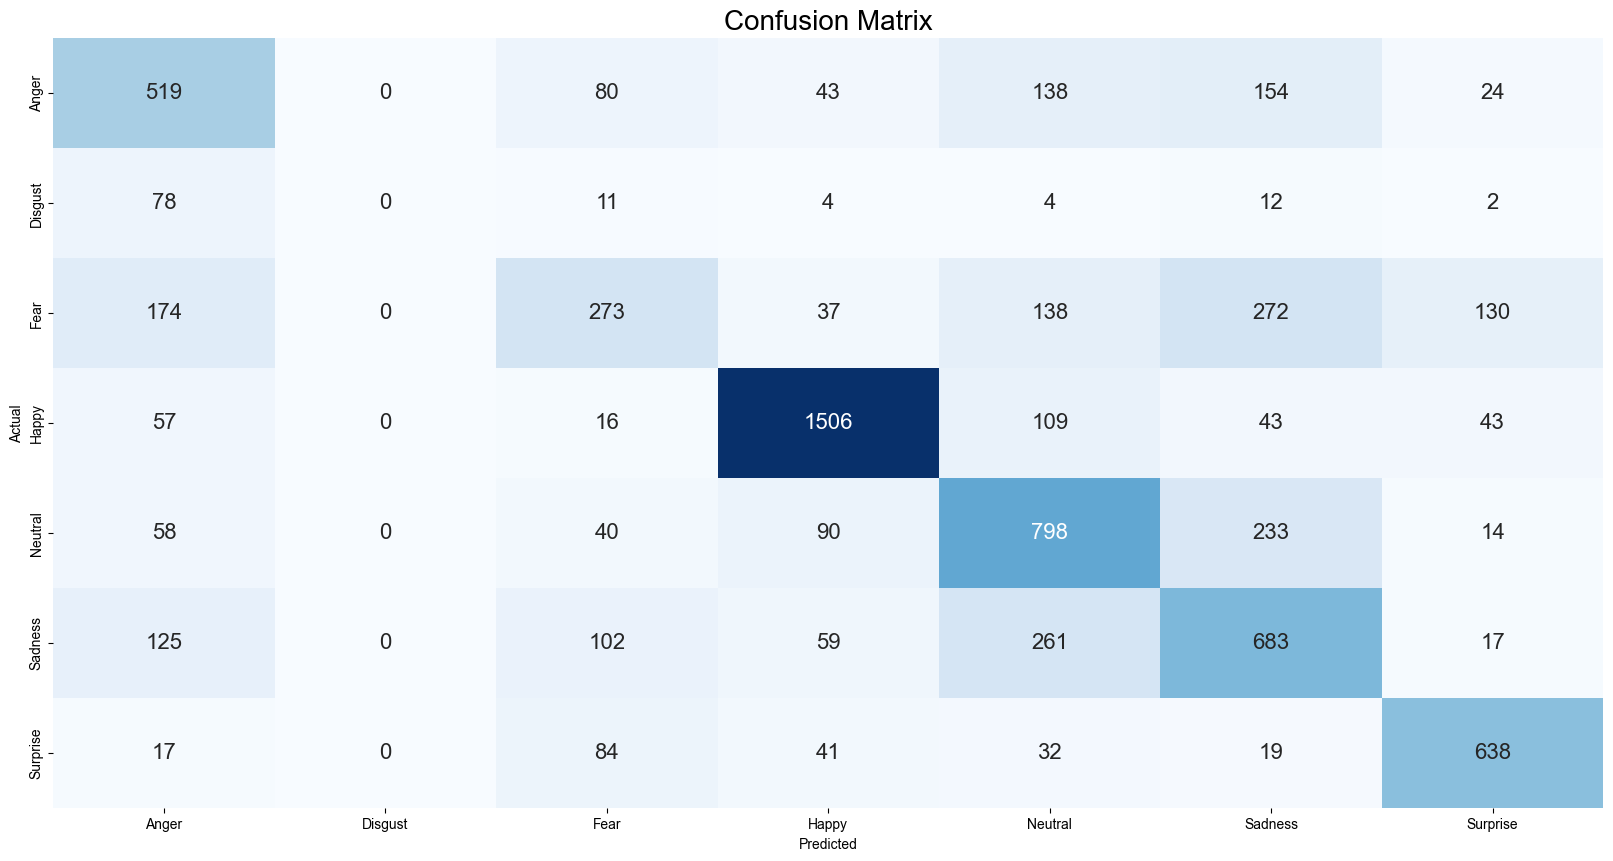

In [42]:
cm_data = confusion_matrix(y_test , y_preds)
cm = pd.DataFrame(cm_data, columns=CLASS_LABELS, index = CLASS_LABELS)
cm.index.name = 'Actual'
cm.columns.name = 'Predicted'
plt.figure(figsize = (20,10))
plt.title('Confusion Matrix', fontsize = 20)
sns.set(font_scale=1.2)
ax = sns.heatmap(cm, cbar=False, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='g')

13. Classification Report

In [45]:
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.50      0.54      0.52       958
           1       0.00      0.00      0.00       111
           2       0.45      0.27      0.33      1024
           3       0.85      0.85      0.85      1774
           4       0.54      0.65      0.59      1233
           5       0.48      0.55      0.51      1247
           6       0.74      0.77      0.75       831

    accuracy                           0.62      7178
   macro avg       0.51      0.52      0.51      7178
weighted avg       0.60      0.62      0.60      7178



14. Multiclass AUC Curve

ROC AUC score: 0.9098853354507803


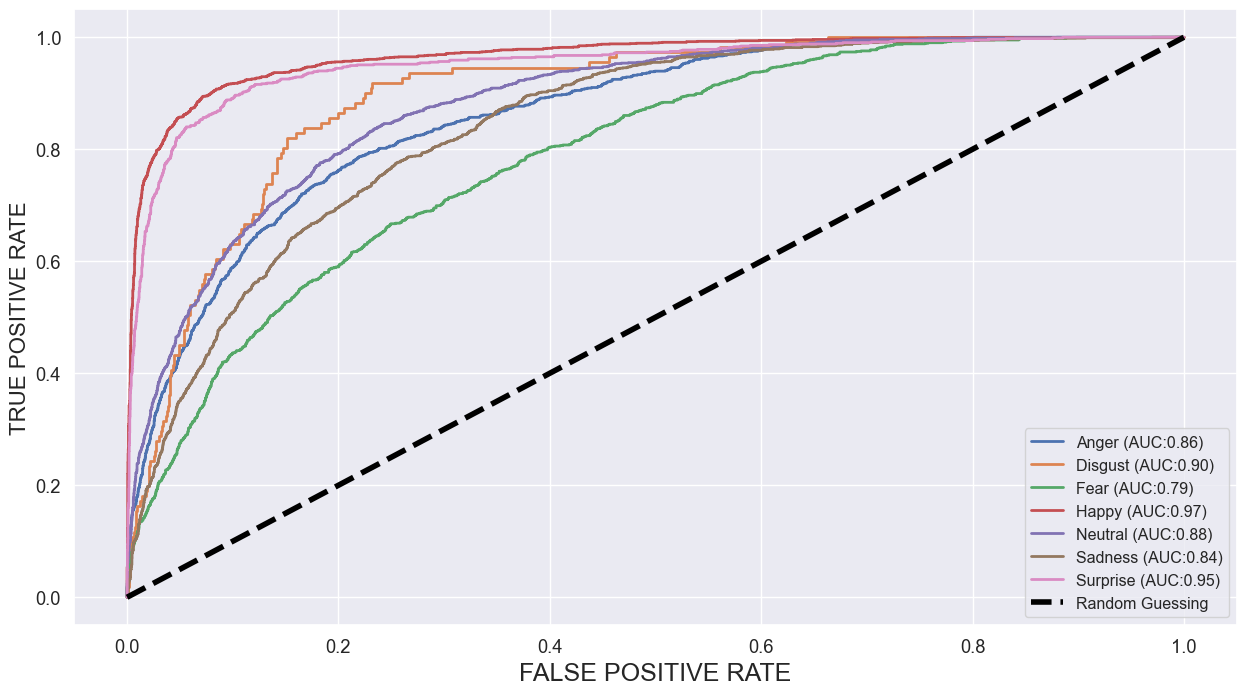

In [46]:
fig, c_ax = plt.subplots(1,1, figsize = (15,8))

def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    for (idx, c_label) in enumerate(CLASS_LABELS):
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr,lw=2, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'black',linestyle='dashed', lw=4, label = 'Random Guessing')
    return roc_auc_score(y_test, y_pred, average=average)

print('ROC AUC score:', multiclass_roc_auc_score(y_test , preds  , average = "micro"))
plt.xlabel('FALSE POSITIVE RATE', fontsize=18)
plt.ylabel('TRUE POSITIVE RATE', fontsize=16)
plt.legend(fontsize = 11.5)
plt.show()

In [47]:
print("ROC-AUC Score  = " ,roc_auc_score(to_categorical(y_test) , preds))

ROC-AUC Score  =  0.8843486057441002
